In [4]:
import nexradaws
from datetime import datetime as datetime
from datetime import timedelta
import pyart
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from cylindrical_conversion import interp_to_equal_grid
from cylindrical_conversion import x_y_grid_to_cylindrical
import pandas as pd

In [5]:
conn = nexradaws.NexradAwsInterface()

In [6]:
time = datetime(2020, 8, 26, 12, 0) # YYYY, MM,DD,HH,MM
startTime = time + timedelta(hours=-12)
endTime = time + timedelta(hours=+12)
storageL2 = '/Users/acheung/data/ground_radar/'
radar_desired = 'KLCH'
radar_Scans = conn.get_avail_scans_in_range(startTime, endTime, radar_desired)
# conn.download(radar_Scans, storageL2) # Downloads the radar files to the location

In [7]:
def process_file(i,point):
    """ Processes a radar file 
    
    Parameters
    ----------
    i: the file number to open
    """
    
    file = radarScans[i].filename
    x = 0
    from distance import distance_calculator
    # Read the file
    radar = pyart.io.read_nexrad_archive(storageL2+'/'+file)       
    sweep_0 = radar.get_slice(0)
    lat = radar.gate_latitude['data'][sweep_0]
    lon = radar.gate_longitude['data'][sweep_0]
    ref = radar.fields['reflectivity']['data'][sweep_0]

    radar_long = radar.longitude['data']
    radar_lat = radar.latitude['data']
    
    # Find reflectivity values within a radius
    dist = distance_calculator(lon, lat, point) # Returns distance array from point
    ind = np.where(dist < 15) # Returns all indices within a distance in km
    latind = ind[0]
    lonind = ind[1]
    refvalue = ref[latind,lonind] # Call reflectivity values within this radius
    
    # Finds the index of the crash site
    ind = np.where(dist == np.min(dist)) # Finds the closest index
    radarlatind = ind[0][0]
    radarlonind = ind[1][0]

    # Calculate Distance from Radar
    distfromradar = distance_calculator(lon,lat,(radar_long,radar_lat))
    radardist = distfromradar[radarlatind,radarlonind]

    namer = file

    # Create Date Time Object
    date_time_str = namer[4:12]+namer[13:19]
    date_time_obj = datetime.strptime(date_time_str, '%Y%m%d%H%M%S')

    return dict(scan=file, refvalue=refvalue, radardist=radardist, date_time_obj=date_time_obj)

In [8]:
# radar = pyart.io.read_nexrad_archive(storageL2+'/'+radarScans[-5].filename)       
# sweep_0 = radar.get_slice(0)
# lat = radar.gate_latitude['data'][sweep_0]
# lon = radar.gate_longitude['data'][sweep_0]
# ref = radar.fields['reflectivity']['data'][sweep_0]

# radar_long = radar.longitude['data']
# radar_lat = radar.latitude['data']
# plt.pcolormesh(x_sort,y_sort,ref[np.argsort(x_grid),np.argsort(y_grid)])
# plt.colorbar()
# # plt.scatter(radar_long,radar_lat)
# plt.scatter(18000,-195000)

In [9]:
radar_Scans[-2]

<AwsNexradFile object - 2020/08/27/KLCH/KLCH20200827_000000_V06>

In [10]:
radar = pyart.io.read_nexrad_archive(storageL2+'/'+radar_Scans[-2].filename)       
test_grid_radar = pyart.map.grid_from_radars(radar,(20,400,400),((0,10000),(-400000,400000),(-400000,400000)))

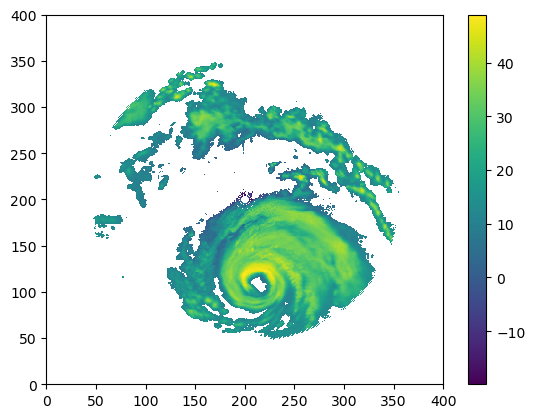

In [91]:
plt.pcolormesh(test_grid_radar.fields['reflectivity']['data'][6])
plt.colorbar()

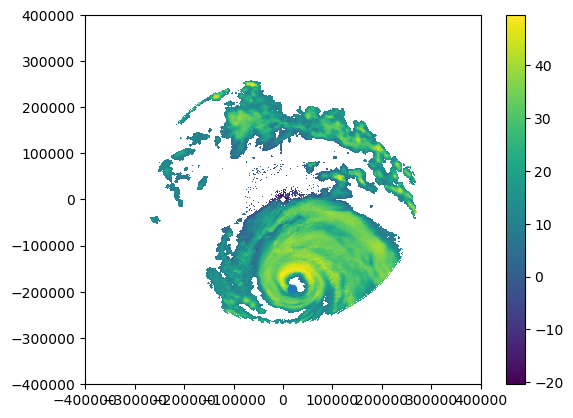

In [92]:
x = test_grid_radar.x['data']
y = test_grid_radar.y['data']
reflectivity = test_grid_radar.fields['reflectivity']['data'][4]
plot = plt.pcolormesh(x,y,reflectivity)
plt.scatter(18000,-195000)
plt.colorbar(plot)

In [93]:
radius_interval = 100
radius_min = 0
radius_max = 200000
center_inds = [-195000,23000]
NOP = 1000
cylindrical_data, THETA, rad_arr = x_y_grid_to_cylindrical(center_inds,radius_min,radius_max,radius_interval, NOP,x,y,reflectivity)



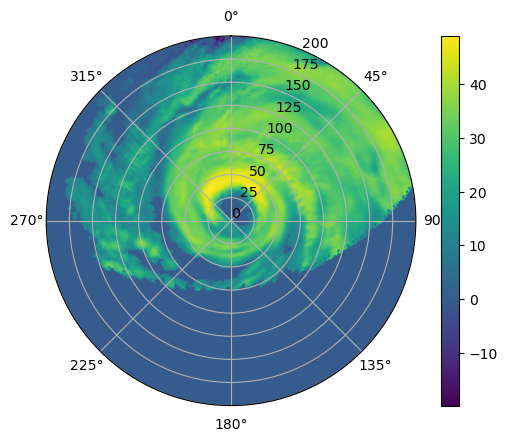

In [94]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.grid(True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
s = ax.pcolormesh(THETA, rad_arr/1000,cylindrical_data)
plt.colorbar(s)

# plt.pcolormesh(cylindrical_data)